In [1]:
from get_file_matches import get_tif_file_matches
from load_train_eval import load_data, train_and_evaluate, visualize_prediction, evaluate_predictions

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [2]:
# Custom DeepLabV3+ with custom backbone for full resolution
def build_custom_deeplabv3_plus(input_shape):
    inputs = layers.Input(input_shape)

    # Custom Backbone (Simple Convolutional Layers, similar to U-Net)
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)  # Downsample

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)  # Downsample

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)  # Downsample

    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)

    # Atrous Spatial Pyramid Pooling (ASPP)
    b0 = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(c4)
    b1 = layers.Conv2D(256, (3, 3), dilation_rate=6, padding="same", activation="relu")(c4)
    b2 = layers.Conv2D(256, (3, 3), dilation_rate=12, padding="same", activation="relu")(c4)
    b3 = layers.Conv2D(256, (3, 3), dilation_rate=18, padding="same", activation="relu")(c4)
    pool = layers.GlobalAveragePooling2D()(c4)
    pool = layers.Reshape((1, 1, pool.shape[-1]))(pool)
    pool = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(pool)
    pool = layers.UpSampling2D(size=(c4.shape[1], c4.shape[2]), interpolation="bilinear")(pool)

    aspp = layers.Concatenate()([b0, b1, b2, b3, pool])
    aspp = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(aspp)

    # Decoder
    low_level_features = c2  # Use features from earlier encoder block
    low_level_features = layers.Conv2D(48, (1, 1), padding="same", activation="relu")(low_level_features)

    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(aspp)
    x = layers.Concatenate()([x, low_level_features])
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)

    # Final upsampling to match input size
    x = layers.UpSampling2D(size=(input_shape[0] // x.shape[1], input_shape[1] // x.shape[2]), interpolation="bilinear")(x)
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(x)

    return models.Model(inputs, outputs)


In [3]:
root_dir = "data/Tschernitz"
folder1 = "output"
folder2 = "ground_truth_masks/forest_masks"

# Match stacked TIF and ground truth mask
matches = get_tif_file_matches(root_dir, folder1, folder2, contains1="final_input", contains2="merged")

# Load Data and Train
X, Y = load_data(matches)

# Normalize inputs and binarize ground truth masks
X = X / 255.0
Y = (Y > 0).astype(np.float32)

Folder1 Path: data/Tschernitz\output
Folder2 Path: data/Tschernitz\ground_truth_masks/forest_masks


In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.5437 - loss: 0.7676 - val_accuracy: 0.6190 - val_loss: 0.6779
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.6339 - loss: 0.6863 - val_accuracy: 0.7408 - val_loss: 0.6845
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7025 - loss: 0.6838 - val_accuracy: 0.6067 - val_loss: 0.6742
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6753 - loss: 0.6607 - val_accuracy: 0.7627 - val_loss: 0.6049
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7725 - loss: 0.5864 - val_accuracy: 0.7678 - val_loss: 0.5200
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7576 - loss: 0.5318 - val_accuracy: 0.7923 - val_loss: 0.4975
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7850 - loss: 0.5127 - val_accuracy: 0.7945 - val_loss: 0.4353
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7928 - loss: 0.4774 - val_accuracy: 0.7868 - val_loss: 0.4504
Epoch 9/25
4/4

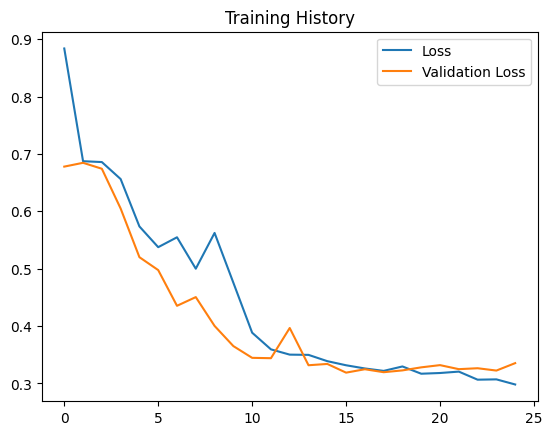

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


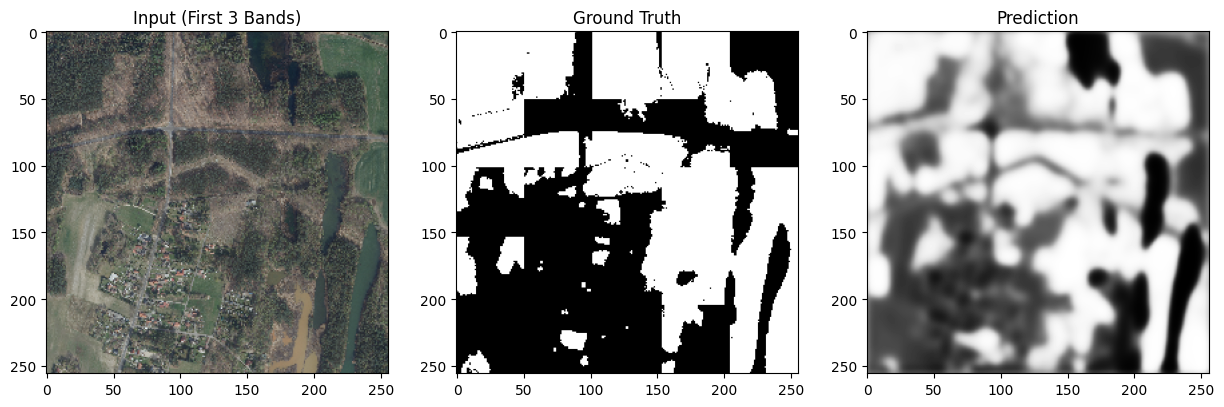

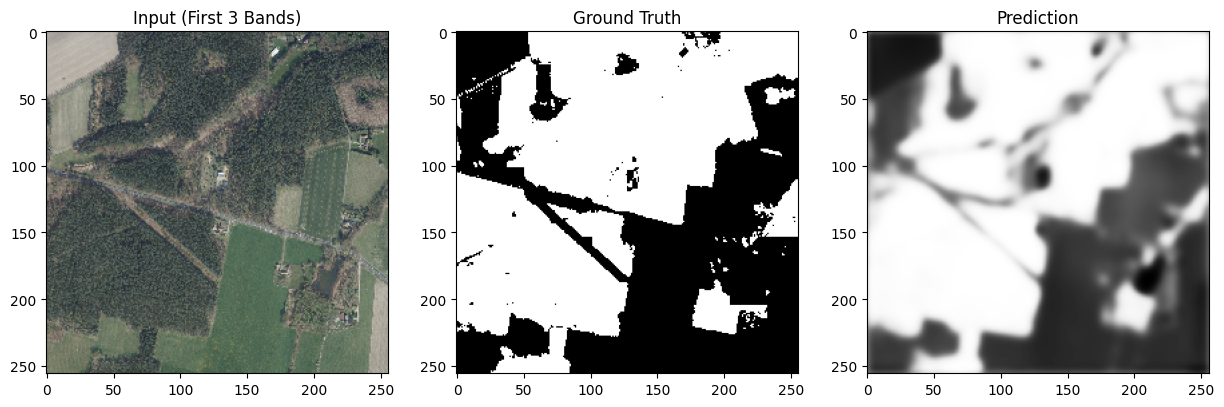

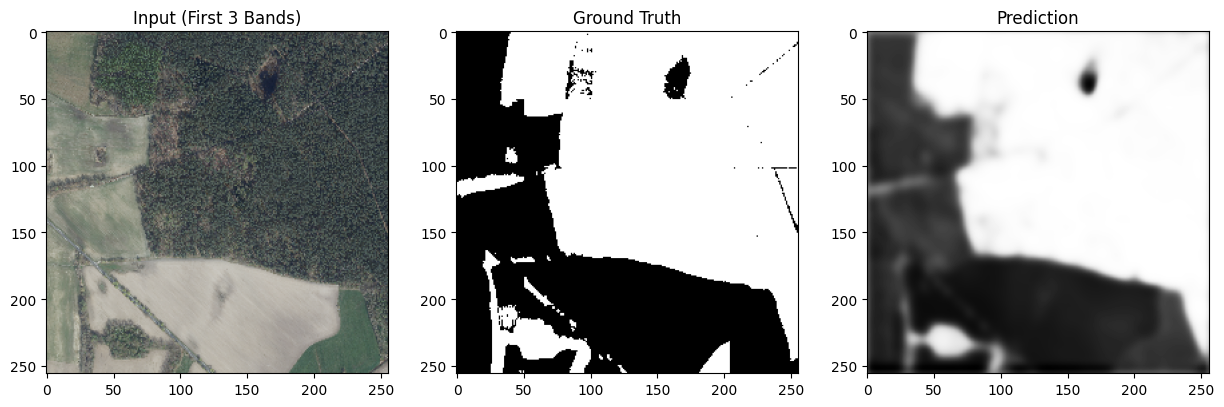

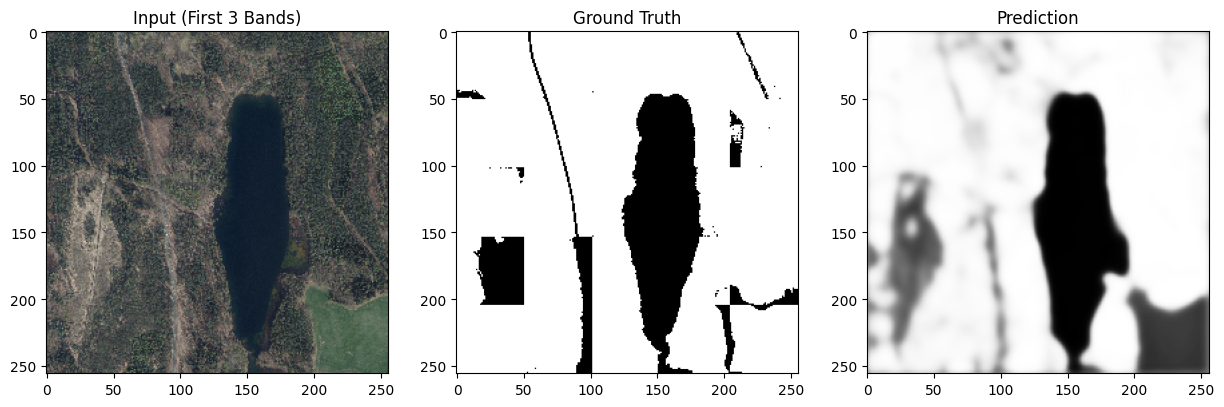

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step

==== Model Evaluation Metrics ====
IoU: 0.8115
Dice: 0.8919
Accuracy: 0.8693
Precision: 0.8751
Recall: 0.9129


In [5]:
# Train U-Net on full resolution
deeplab_results_full = train_and_evaluate(X_train, Y_train, X_val, Y_val, build_custom_deeplabv3_plus, batch_size=4, epochs=25)

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - accuracy: 0.6279 - loss: 0.7816 - val_accuracy: 0.6190 - val_loss: 0.6908
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 9s/step - accuracy: 0.5787 - loss: 0.6926 - val_accuracy: 0.6190 - val_loss: 0.6910
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.6004 - loss: 0.6914 - val_accuracy: 0.6190 - val_loss: 0.6825
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.5762 - loss: 0.6840 - val_accuracy: 0.6190 - val_loss: 0.6799
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.5638 - loss: 0.7378 - val_accuracy: 0.6190 - val_loss: 0.6841
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 14s/step - accuracy: 0.6159 - loss: 0.6840 - val_accuracy: 0.6190 - val_loss: 0.6860
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 14s/step - accuracy: 0.5931 - loss: 0.6875 - val_accuracy: 0.7321 - val_loss: 0.6845
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 12s/step - accuracy: 0.7291 - loss: 0.6835 - val_accuracy: 0.7645 - val_loss: 0.6777
Epoch

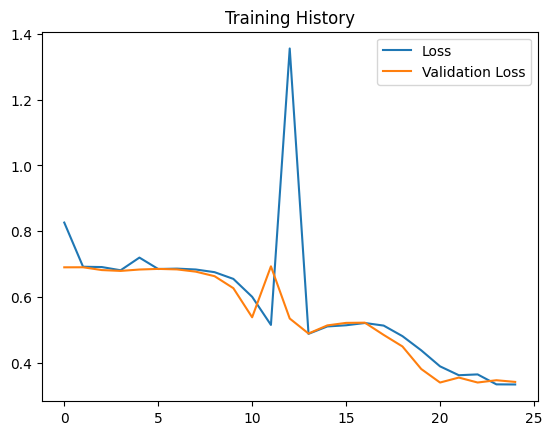

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


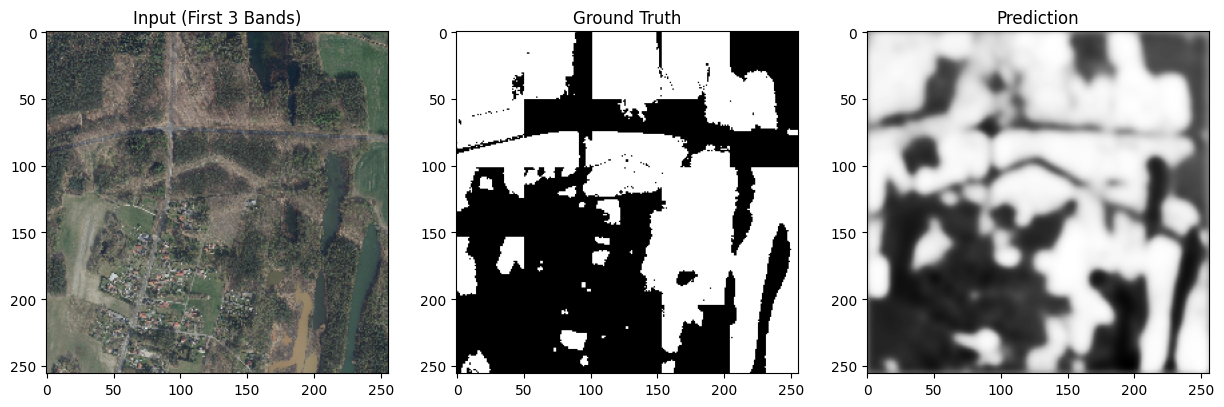

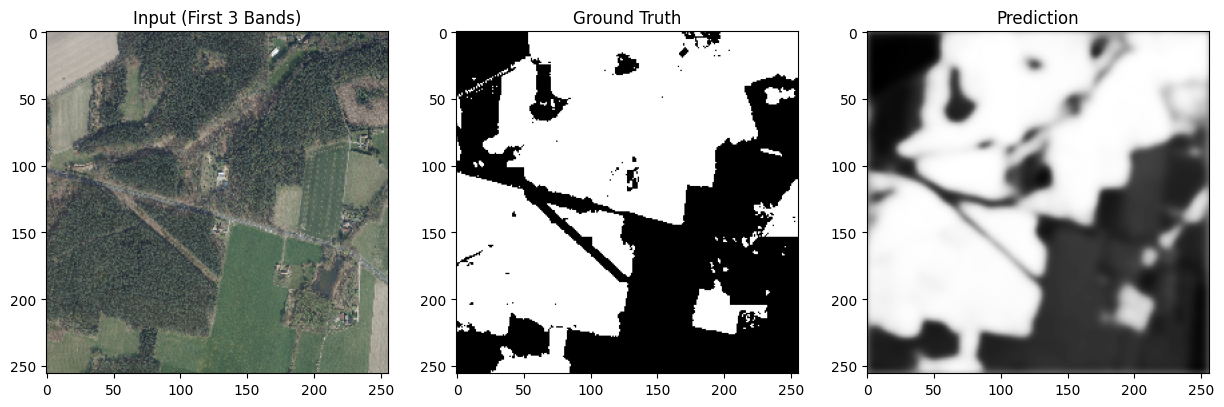

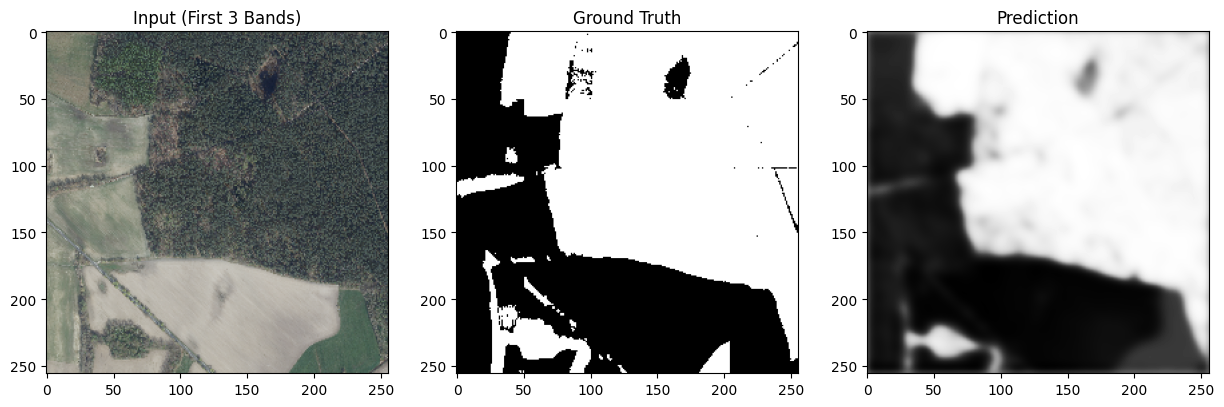

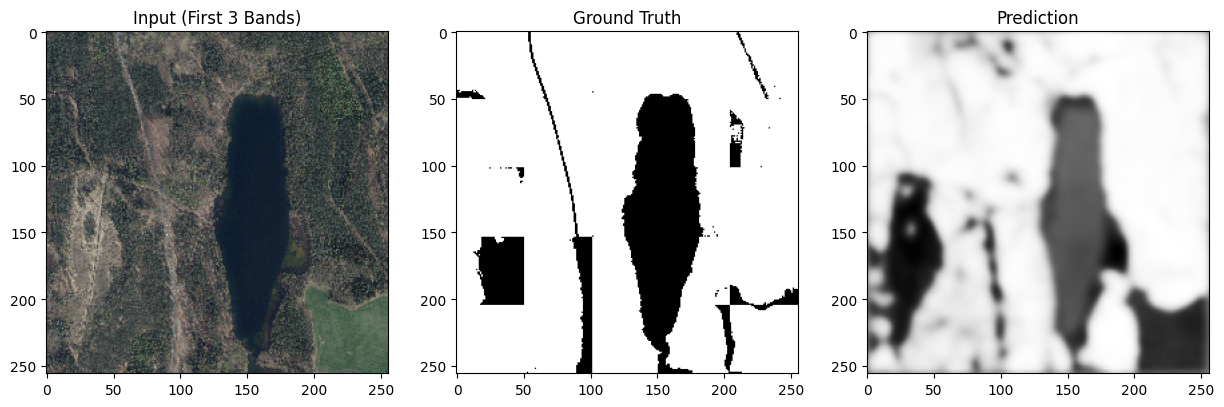

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

==== Model Evaluation Metrics ====
IoU: 0.8010
Dice: 0.8863
Accuracy: 0.8605
Precision: 0.8740
Recall: 0.9026


In [6]:
# Train U-Net on full resolution
deeplab_results_full = train_and_evaluate(X_train, Y_train, X_val, Y_val, build_custom_deeplabv3_plus, batch_size=8, epochs=25)

In [7]:
from augmentation_pipeline import augment_dataset, plot_original_and_augmented_versions

augment_configs = [
    {"RandomRotate90": 0.5, "HorizontalFlip": 0.5},
    {"ShiftScaleRotate": {"shift_limit": 0.01, "scale_limit": 0.05, "rotate_limit": 15, "p": 0.5}},
    {"RandomBrightnessContrast": {"brightness_limit": 0.1, "contrast_limit": 0.1, "p": 0.5}},
    {"GaussNoise": {"var_limit": (5.0, 25.0), "p": 0.3}},
]
"""results = {}
for i, config in enumerate(augment_configs):
    print(f"\nApplying Augmentation Configuration {i+1}/{len(augment_configs)}: {config}")
    X_train_aug, Y_train_aug = augment_dataset(X_train, Y_train, config, num_versions=2)
    results[f"Config_{i+1}"] = train_and_evaluate(X_train_aug, Y_train_aug, X_val, Y_val, build_custom_deeplabv3_plus, visualize=False)
"""
# Plot the first 3 images and their augmented versions
#plot_original_and_augmented_versions(X_train[:3], X_train_aug, num_samples=3, num_versions=5)

'results = {}\nfor i, config in enumerate(augment_configs):\n    print(f"\nApplying Augmentation Configuration {i+1}/{len(augment_configs)}: {config}")\n    X_train_aug, Y_train_aug = augment_dataset(X_train, Y_train, config, num_versions=2)\n    results[f"Config_{i+1}"] = train_and_evaluate(X_train_aug, Y_train_aug, X_val, Y_val, build_custom_deeplabv3_plus, visualize=False)\n'